In [1]:
# this path append is for binder only
import sys
sys.path.append("../../")

#spectrome modules
from spectrome.forward import runforward, runforward_spatialcorrelation_topalpha
from spectrome.utils import functions, path
from spectrome.brain import Brain
from spectrome.forward import localstability_microintensity
from spectrome.forward import network_transfer_macrostable_microintensity_extrastimulus as nt

#generic modules
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import pickle as pkl
from scipy import stats
from scipy.stats import pearsonr
from scipy.io import loadmat

plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

In [2]:
# ind_psd_xr = xr.open_dataarray(data_dir + '/individual_psd_reordered_smooth.nc')
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values

ind_regions = ind_psd_xr["regionx"].values

In [3]:
ind_regions

array(['LHbankssts', 'LHcaudalanteriorcingulate', 'LHcaudalmiddlefrontal',
       'LHcuneus', 'LHentorhinal', 'LHfusiform', 'LHinferiorparietal',
       'LHinferiortemporal', 'LHisthmuscingulate', 'LHlateraloccipital',
       'LHlateralorbitofrontal', 'LHlingual', 'LHmedialorbitofrontal',
       'LHmiddletemporal', 'LHparahippocampal', 'LHparacentral',
       'LHparsopercularis', 'LHparsorbitalis', 'LHparstriangularis',
       'LHpericalcarine', 'LHpostcentral', 'LHposteriorcingulate',
       'LHprecentral', 'LHprecuneus', 'LHrostralanteriorcingulate',
       'LHrostralmiddlefrontal', 'LHsuperiorfrontal',
       'LHsuperiorparietal', 'LHsuperiortemporal', 'LHsupramarginal',
       'LHfrontalpole', 'LHtemporalpole', 'LHtransversetemporal',
       'LHinsula', 'RHbankssts', 'RHcaudalanteriorcingulate',
       'RHcaudalmiddlefrontal', 'RHcuneus', 'RHentorhinal', 'RHfusiform',
       'RHinferiorparietal', 'RHinferiortemporal', 'RHisthmuscingulate',
       'RHlateraloccipital', 'RHlateralorb

In [4]:
visual_regions = ['LHlingual','LHpericalcarine','LHcuneus','LHlateraloccipital','LHsuperiorparietal','LHtemporalpole',
                  'LHfusiform','LHinferiortemporal','RHlingual','RHpericalcarine','RHcuneus','RHlateraloccipital',
                  'RHsuperiorparietal','RHtemporalpole','RHfusiform','RHinferiortemporal']
                  

In [5]:
d = {x: a for a, x in enumerate(ind_regions)}
orderedind = [d[x] for x in visual_regions]

In [6]:
orderedind

[11, 19, 3, 9, 27, 31, 5, 7, 45, 53, 37, 43, 61, 65, 39, 41]

In [7]:
for i in range(len(visual_regions)):
    assert ind_regions[orderedind[i]] == visual_regions[i]

In [8]:
ind_regions[orderedind]

# Only use cuneus. Visual eye projection goes. 
#  Can also include lateral occipital

array(['LHlingual', 'LHpericalcarine', 'LHcuneus', 'LHlateraloccipital',
       'LHsuperiorparietal', 'LHtemporalpole', 'LHfusiform',
       'LHinferiortemporal', 'RHlingual', 'RHpericalcarine', 'RHcuneus',
       'RHlateraloccipital', 'RHsuperiorparietal', 'RHtemporalpole',
       'RHfusiform', 'RHinferiortemporal'], dtype=object)

In [9]:
def run_local_coupling_forward(brain, params, freqs):

    eigenvalues = []
    eigenvectors = []
    frequency_response = []
    model_out = []

    for freq in freqs:
        w = 2 * np.pi * freq
        freq_model, freq_resp, eig_val, eig_vec = nt.network_transfer_local_alpha(
            brain, params, w
        )
        frequency_response.append(freq_resp)
        eigenvalues.append(eig_val)
        eigenvectors.append(eig_vec)
        model_out.append(freq_model)

    frequency_response = np.asarray(frequency_response)
    eigenvalues = np.asarray(eigenvalues)
    eigenvectors = np.asarray(eigenvectors)
    model_out = np.transpose(np.asarray(model_out))

    return model_out, frequency_response, eigenvalues, eigenvectors

def run_local_coupling_forward_Xk(brain, params, freqs, PSD, SC, rois_with_MEG, band):

    if band == "alpha":
        freqband = np.where((freqs>=8) & (freqs<=12))[0]
    if band == "beta":
        freqband = np.where((freqs>=13) & (freqs<=25))[0]

    eigvec_ns = np.zeros((len(rois_with_MEG),len(freqband)))

    for i in range(len(freqband)):
        w = 2 * np.pi * freqs[freqband[i]]
        eigenvectors_ns, _, _, _ = nt.network_transfer_local_alpha(
            brain, params, w
        )

        eigvec_ns[:,i] = eigenvectors_ns[rois_with_MEG]

    eigvec_ns_summed = np.sum(eigvec_ns,axis = 1)

    eigvec_summed = eigvec_ns_summed/np.linalg.norm(eigvec_ns_summed)

    summed_PSD = np.sum(PSD[:,freqband], axis = 1)

    summed_PSD = summed_PSD/np.linalg.norm(summed_PSD)

    w_spat = 10.0

    C = brain.reducedConnectome
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    Cc = np.matmul(np.diag(L2), C)
    
    C2 = Cc + w_spat*np.eye(86)
    rowdegree = np.transpose(np.sum(C2, axis=1))
    coldegree = np.sum(C2, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    L22 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    Cc2 = np.matmul(np.diag(L22), C2)    
    
    
    func1 = np.matmul(Cc2[0:68,0:68], summed_PSD)
    
    cost_func =  np.matmul(np.transpose(eigvec_summed),func1)
    
    # return cost_func
    return summed_PSD, eigvec_summed    

In [10]:
def getpsd(cdk,psd,rois_with_MEG,fvec,lpf,s,df_in):

    C_ind = cdk[:,:,s] # grab current subject's individual connectome
    F_ind = psd[:,:,s] # grab current subject's MEG

    data_dir = path.get_data_path()
    # create spectrome brain:
    brain = Brain.Brain()
    brain.add_connectome(data_dir) # grabs distance matrix
    # re-ordering for DK atlas and normalizing the connectomes:
    brain.reorder_connectome(brain.connectome, brain.distance_matrix)
    brain.connectome = C_ind # re-assign connectome to individual connectome
    # brain.connectome = SC_volnorm_template
    brain.bi_symmetric_c()
    brain.reduce_extreme_dir()
#     brain.distance_matrix = get_mean_C(brain.distance_matrix)

    brain.ntf_params["tau_e"] = df_in['tau_e'][s]/1000
    brain.ntf_params["tau_i"] = df_in['tau_i'][s]/1000
    brain.ntf_params["alpha"] = df_in['alpha'][s]
    brain.ntf_params["speed"] = df_in['speed'][s]
    brain.ntf_params["gei"] = df_in['gei'][s]
    brain.ntf_params["gii"] = df_in['gii'][s]
    brain.ntf_params["tauC"] = df_in['tauC'][s]/1000

    model_spectrum, _, _, _ = run_local_coupling_forward(brain, brain.ntf_params, fvec)

    model_spectrum = model_spectrum[rois_with_MEG,:]
    
    filfinal = 0
    for g in range(len(model_spectrum)):
        spectrum = np.abs(model_spectrum[g,:])
        # filtered = functions.mag2db(np.convolve(spectrum, lpf, 'same'))
        
        filtered = functions.mag2db(spectrum)
#         filtered = (filtered - np.mean(filtered))/(np.std(filtered))
        filfinal += filtered

    filfinal = filfinal/len(model_spectrum)

    # Return average psd for a specific subject (old or new depending on choice)

    meg_spat, model_spat = run_local_coupling_forward_Xk(brain, brain.ntf_params, fvec, F_ind, 86, rois_with_MEG,"alpha")
    
    return filfinal, meg_spat, model_spat



In [11]:
# define data directory
data_dir = path.get_data_path()

# cortical areas with MEG collected + source reconstructed
rois_with_MEG = np.arange(0,68)


## Load MEG:
## individual connectomes, this is a Nregion x Nregion x Nsubjects array:
ind_conn_xr = xr.open_dataarray('../data/individual_connectomes_reordered.nc')
ind_conn = ind_conn_xr.values

# ind_psd_xr = xr.open_dataarray(data_dir + '/individual_psd_reordered_smooth.nc')
ind_psd_xr = xr.open_dataarray('../data/individual_psd_reordered_matlab.nc')
ind_psd = ind_psd_xr.values

fvec = ind_psd_xr["frequencies"].values

lpf = np.array([1, 2, 3, 2, 1])
lpf = lpf/np.sum(lpf)

w_10I_ind_stableg_microint_highv = np.loadtxt("/data/rajlab1/user_data/parul/spectromeP_results/results_globalSGM/chang_tauiu200_g10_macrostable_spatial_pw1_nodb/onlyuk_1spectral_1spatial_10weightedcorr_org_ind_microint_highspeed_stableg.csv",delimiter=",")
w_10I_ind_stableg_microint_highv_sorted = w_10I_ind_stableg_microint_highv[np.argsort(w_10I_ind_stableg_microint_highv[:,10])]

w_chosen = w_10I_ind_stableg_microint_highv_sorted

df_params=pd.DataFrame({'tau_e':w_chosen[:,0], 'tau_i':w_chosen[:,1], 'alpha':w_chosen[:,2], 'speed':w_chosen[:,3], 'gei':w_chosen[:,4], 'gii':w_chosen[:,5], 'tauC':w_chosen[:,6]})


In [12]:
nsubs = len(w_chosen[:,0])
new_spectra = 0
org_spectra_overall = 0
meg_spat_tot = 0
model_spat_tot = 0

for i in range(nsubs):
    
    spec_predicted, meg_spat, model_spat = getpsd(ind_conn,ind_psd,rois_with_MEG,fvec,lpf,i,df_params)
    new_spectra += spec_predicted
    meg_spat_tot += meg_spat
    model_spat_tot += model_spat

    org_spectra = 0
    for g in rois_with_MEG:
        # spectrum = ind_psd[g,:,i]
        spectrum = functions.mag2db(ind_psd[g,:,i])
#         spectrum = (spectrum - np.mean(spectrum))/(np.std(spectrum))
        org_spectra += spectrum
    org_spectra = org_spectra/len(rois_with_MEG)

    org_spectra_overall += org_spectra

new_spectra = new_spectra/nsubs
org_spectra_overall = org_spectra_overall/nsubs

meg_spat_tot = meg_spat_tot/nsubs
model_spat_tot = model_spat_tot/nsubs

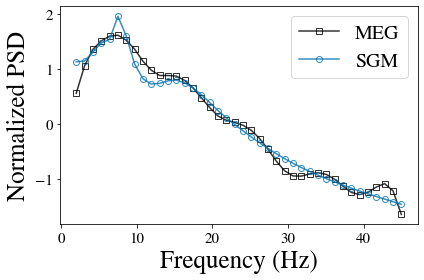

In [13]:
plt.rcParams.update({
    "mathtext.fontset": "stix",
    "font.family": "STIXGeneral",
    "xtick.labelsize": 15,
    "ytick.labelsize": 15
})

new_c = '#0571b0'

new_normalized = (new_spectra - np.mean(new_spectra))/(np.std(new_spectra))
org_normalized = (org_spectra_overall - np.mean(org_spectra_overall))/(np.std(org_spectra_overall))

colorp = sns.color_palette("colorblind",n_colors=3)

fig, ax = plt.subplots()


ax.plot(fvec,org_normalized,linestyle = '-',marker = 's',fillstyle = 'none',color = 'k', label = "MEG", alpha = 0.8)
ax.plot(fvec,new_normalized,linestyle = '-',marker = 'o',fillstyle = 'none',color = new_c, label = "SGM", alpha = 0.8)

ax.legend(fontsize = 20)
ax.set_xlabel('Frequency (Hz)', fontsize = 25)
ax.set_ylabel('Normalized PSD', fontsize = 25)

plt.tight_layout()


In [14]:
# filename = f'/data/rajlab1/user_data/parul/spectrome-spatial_results/results/spatial/visual/notallstable_wrongq1.p'
# with open(filename, 'wb') as f:
#     pkl.dump(model_spat_tot, f) 

In [15]:
Pw = np.ones((86,1))
visual_stimulus_roi = np.array([11, 19, 3, 9, 27, 31, 5, 7, 45, 53, 37, 43, 61, 65, 39, 41])

Pw[visual_stimulus_roi] *= 2

Htotal_micro = np.ones((86,1),dtype="complex")

Htotal_micro_vis = np.multiply(Htotal_micro,Pw)

Htotal_micro_vis.shape

(86, 1)